# 2002 CVE Data Growth Review

In [1]:
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2002..2022}.json.zip 
!unzip -o "*.zip" 

In [2]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import datetime
from datetime import date
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import warnings
import seaborn as sns

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)



nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvdcount = nvd['Published'].count()
startdate = date(2000, 1, 1)
enddate  = date.today()
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days


In [4]:

Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **191708**<br />Average CVEs Per Day: **22.83**<br />Average CVSS Score: **7.21**

In [5]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
Month_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
Year_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("Y")).agg('count')
Week_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("W")).agg('count')
Day_Graph = nvd['Published'].groupby(nvd.Published.dt.to_period("D")).agg('count')

#### Per Year

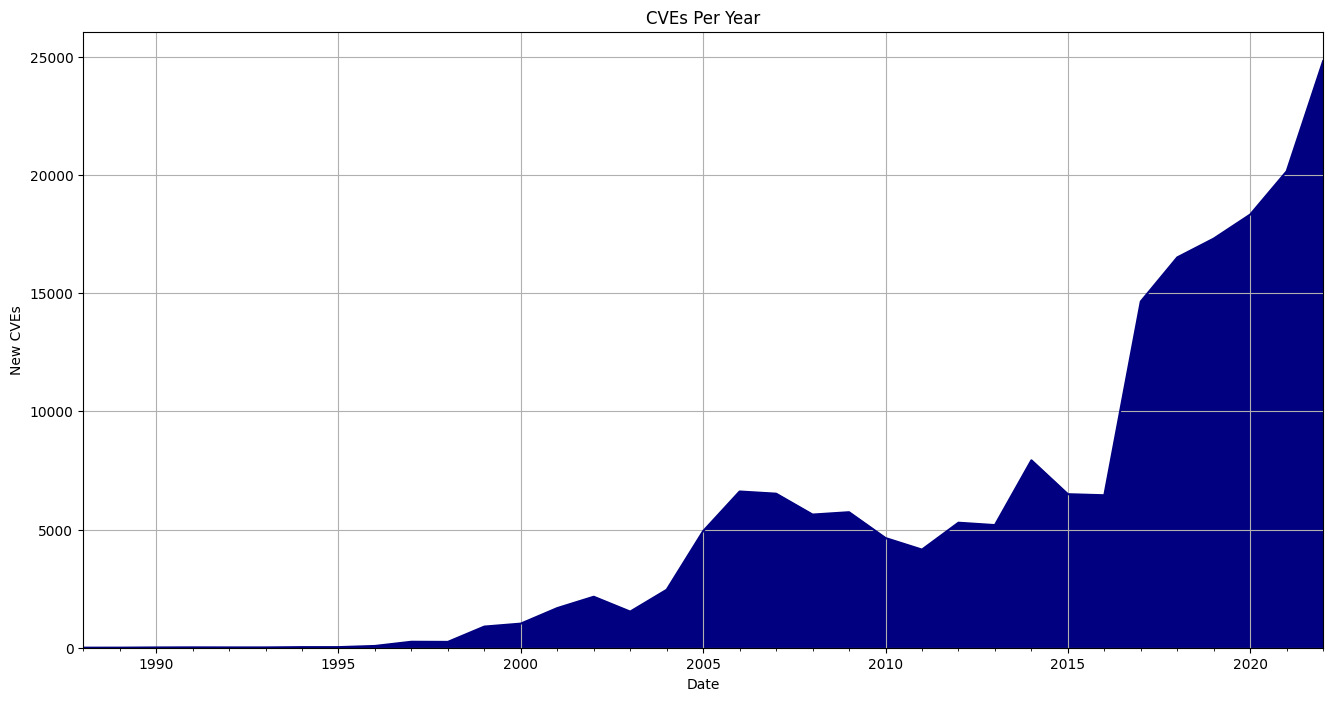

In [6]:
cg = Year_Graph.plot.area(colormap='jet', figsize=(16, 8), title='CVEs Per Year')
plt.grid()
cg.set_ylabel("New CVEs");
cg.set_xlabel("Date");

In [7]:
Markdown(f"## CVE Growth Data")

## CVE Growth Data

In [8]:
yg_df = pd.DataFrame(Year_Graph)
yg_df.columns = ['Count']
yg_df = yg_df.reset_index()
yg_df['Percentage'] = ( yg_df['Count'] / 
                       yg_df['Count'].sum()) * 100
yg_df['Percentage_Change_YOY'] = yg_df['Count'].pct_change()*100
yg_df.round(2)

,Published,Count,Percentage,Percentage_Change_YOY
0,1988,2,0.00,NaN
1,1989,3,0.00,50.00
2,1990,11,0.01,266.67
3,1991,15,0.01,36.36
4,1992,13,0.01,-13.33
5,1993,13,0.01,0.00
6,1994,25,0.01,92.31
7,1995,25,0.01,0.00
8,1996,74,0.04,196.00
9,1997,252,0.13,240.54


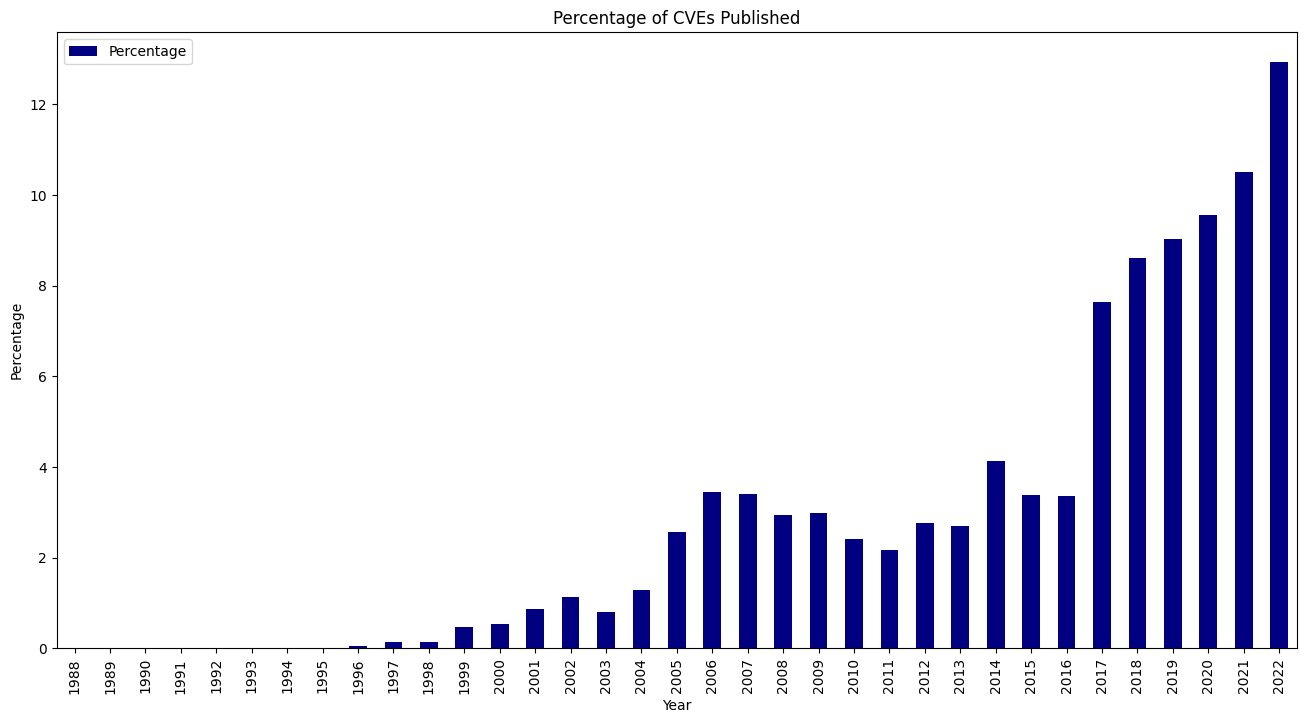

In [9]:
cg = yg_df.plot.bar(x='Published', y='Percentage', colormap='jet', figsize=(16, 8), title='Percentage of CVEs Published')
cg.set_ylabel("Percentage");
cg.set_xlabel("Year");

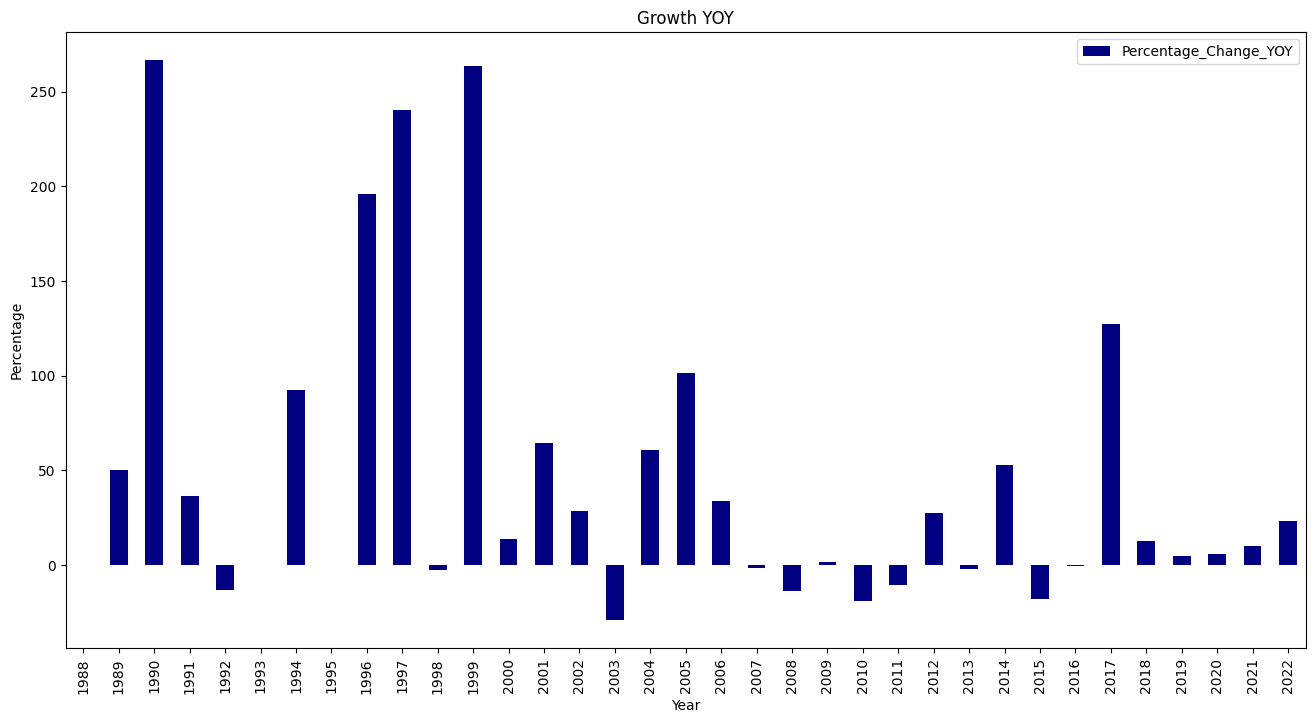

In [10]:
cg = yg_df.plot.bar(x='Published', y='Percentage_Change_YOY', colormap='jet', figsize=(16, 8), title='Growth YOY')
cg.set_ylabel("Percentage");
cg.set_xlabel("Year");